In [1]:
%matplotlib inline
from pprint import pprint
from collections import defaultdict

import numpy as np
import math
import matplotlib.pyplot as plt
import random
import warnings

#from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import SGDClassifier
import sklearn.tree
import sklearn.ensemble

from sklearn.grid_search import GridSearchCV
from sklearn import metrics

import sys
sys.path.append('../dev')

from ml_plot import plot_validation_curve
from ml_plot import PredictCV, my_plot_learning_curve
from ml_plot import plot_prediction_curve
from ml_plot import get_dataset, eval_predictions

# Configuration

In [2]:
# PROJECT = 'nova'
# PROJECT = 'swift'
# PROJECT = 'cinder'
PROJECT = 'heat'
# PROJECT = 'glance'

# IMPORTANCE = 'crit'
# IMPORTANCE = 'high+'
IMPORTANCE = 'med+'
# IMPORTANCE = 'low+'

# SIZE = 100
#SIZE = 250
# SIZE = 0.1
SIZE = 0.5

SCORING = 'f1'         # (precision * recall) / (precision + recall)
# SCORING = 'accuracy'   # (TP + TN) / all values
# SCORING = 'precision'  # TP / (TP + FP)
# SCORING = 'recall'     # TP / (TP + FN)
# SCORING = 'average_precision'
# SCORING = 'roc_auc'

JOBS = 4

VERBOSE = 0

#warnings.simplefilter("ignore", UndefinedMetricWarning)
warnings.filterwarnings('ignore', 'F-score is ill-defined')
warnings.filterwarnings('ignore', 'overflow encountered in exp')

# Load Data

In [3]:
%%capture
Y, X = get_dataset(PROJECT, IMPORTANCE)

### Select Split Strategy

In [4]:
cv = PredictCV(len(Y), history=500, future=300, n_iter=10)

# Gradient Tree

In [5]:
estimator = sklearn.ensemble.GradientBoostingClassifier()
param_grid = {'learning_rate': [0.5, 1.0, 2.0],
              'n_estimators': [25, 50, 100],
              'max_features': [None, 'auto', 'log2']}

In [6]:
grid = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=SCORING,
                    n_jobs=JOBS, pre_dispatch=2*JOBS, verbose=VERBOSE)
grid.fit(X, Y)
print 'best_score: ', grid.best_score_
clf = grid.best_estimator_
grid.best_estimator_

best_score:  0.470934729591


GradientBoostingClassifier(init=None, learning_rate=0.5, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2, n_estimators=25,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Validation Curve

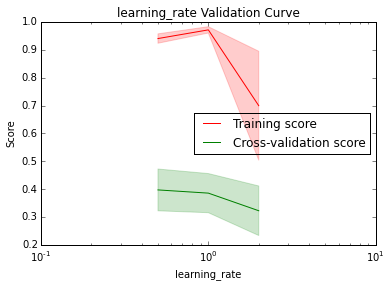

Best score of 0.397588342302 when setting learning_rate to 0.5


In [7]:
best_score, param_val, param_name = \
    plot_validation_curve(clf,
                          X, Y,
                          "learning_rate", [0.5, 1.0, 2.0],
                          "learning_rate Validation Curve",
                          cv=cv, scoring=SCORING, n_jobs=JOBS)
print 'Best score of', best_score, 'when setting', param_name, 'to',  param_val

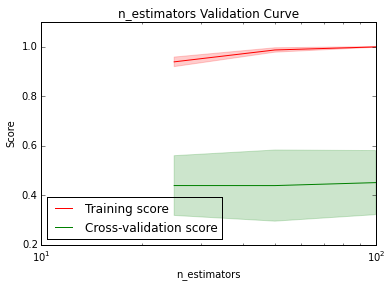

Best score of 0.451739762055 when setting n_estimators to 100


In [8]:
best_score, param_val, param_name = \
    plot_validation_curve(clf,
                          X, Y,
                          "n_estimators", [25, 50, 100],
                          "n_estimators Validation Curve",
                          cv=cv, scoring=SCORING, n_jobs=JOBS)
print 'Best score of', best_score, 'when setting', param_name, 'to',  param_val

### Learning Curve

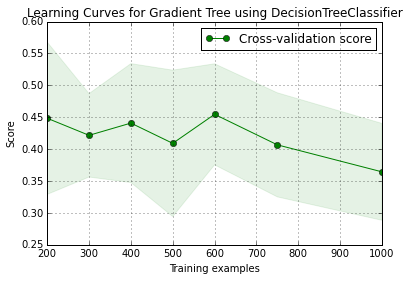

In [9]:
title = "Learning Curves for Gradient Tree using DecisionTreeClassifier"
my_plot_learning_curve(clf, title, X, Y,
                           n_jobs=JOBS, future=500,
                           history_sizes=[200, 300, 400, 500, 600, 750, 1000])
plt.show()

### Prediction Curve

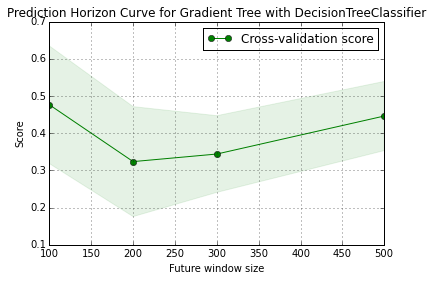

In [10]:
title = "Prediction Horizon Curve for Gradient Tree with DecisionTreeClassifier"
plot_prediction_curve(clf, title, X, Y,
                           n_jobs=JOBS, history=500,
                           future_sizes=[100, 200, 300, 500])
plt.show()

In [11]:
GT_results = eval_predictions(clf, X, Y, history_sizes=[500, 1000], future_sizes=[100, 300, 500])

** Predictions for hist=500 future=100 **

F1:        0.41  +/- 0.17
Accuracy:  0.62  +/- 0.19
Precision: 0.47  +/- 0.20
Recall:    0.48  +/- 0.30

Aggregate Confusion Matrix - 10 iterations
[[466 219]
 [159 156]]


** Predictions for hist=500 future=300 **

F1:        0.41  +/- 0.07
Accuracy:  0.67  +/- 0.13
Precision: 0.44  +/- 0.13
Recall:    0.48  +/- 0.23

Aggregate Confusion Matrix - 10 iterations
[[1634  598]
 [ 394  374]]


** Predictions for hist=500 future=500 **

F1:        0.44  +/- 0.07
Accuracy:  0.74  +/- 0.04
Precision: 0.46  +/- 0.08
Recall:    0.44  +/- 0.11

Aggregate Confusion Matrix - 10 iterations
[[3133  639]
 [ 676  552]]


** Predictions for hist=1000 future=100 **

F1:        0.44  +/- 0.09
Accuracy:  0.73  +/- 0.08
Precision: 0.55  +/- 0.16
Recall:    0.40  +/- 0.13

Aggregate Confusion Matrix - 10 iterations
[[615 107]
 [165 113]]


** Predictions for hist=1000 future=300 **

F1:        0.38  +/- 0.13
Accuracy:  0.76  +/- 0.05
Precision: 0.44  +/- 0.14
Recal

In [12]:
GT_clf = clf